In [1]:
%load_ext autoreload
%autoreload 2

In [47]:
import requests
from datetime import datetime, timezone, timedelta
import pandas as pd
from pandas.io.json import json_normalize
from data_loader.data_generator import DataGenerator
from models.lstm_model import LSTMModel
from models.mlp_model import MLPModel
from models.adversarial_attentive_lstm import AdvLSTMModel
from trainers.trainer import Trainer
from utils.dirs import create_dirs
from utils.logger import Logger
import json
from utils.config import process_config
import tensorflow as tf
import shutil
from evalers.evaler import Evaler
import numpy as np
import matplotlib.pyplot as plt
import os
from pytrends.request import TrendReq
from matplotlib.pyplot import figure
from finta import TA

In [6]:
def download_ohlcv(symbol, start_date, end_date):
    date_iterator = start_date - timedelta(hours=1)
    
    ohlcv_df = pd.DataFrame()
    
    while date_iterator < end_date:
        delta = timedelta(seconds=min((end_date - date_iterator).total_seconds(), 2000 * 3600))
        limit = delta.total_seconds() // 3600 - 1
        date_iterator += delta
        
        params={
            'fsym': symbol,
            'tsym': 'USD',
            'limit': limit,
            'toTs': date_iterator.timestamp(),
            'aggregate': 4
        }
        
        r = requests.get('https://min-api.cryptocompare.com/data/histohour', params=params)
        data = json_normalize(r.json(), record_path="Data")
        ohlcv_df = ohlcv_df.append(data)
    
    ohlcv_df['time'] = pd.to_datetime(ohlcv_df['time'], unit='s')
    ohlcv_df.set_index('time', inplace=True)
    ohlcv_df = ohlcv_df.tz_localize('UTC')
    ohlcv_df = ohlcv_df[~ohlcv_df.index.duplicated(keep='last')]
    
    return ohlcv_df

In [7]:
start_date = datetime(2018, 1, 30, 0)
end_date = datetime(2018, 9, 30, 0)
symbol = 'BTC'
keyword = 'Bitcoin'

In [8]:
ohlcv_df = download_ohlcv(symbol, start_date, end_date)

In [9]:
data_df = ohlcv_df.copy()
data_df.drop(columns=['volumeto'], inplace=True)
data_df.rename(columns={'volumefrom': 'volume'}, inplace=True)

In [10]:
data_df['RSI_14'] = TA.RSI(ohlcv_df)
data_df['STOCHRSI_9_6'] = TA.STOCHRSI(ohlcv_df)
data_df['MACD_12_26'] = TA.MACD(ohlcv_df)['MACD']
data_df['ADX_14'] = TA.ADX(ohlcv_df)
data_df['WILLIAMS'] = TA.WILLIAMS(ohlcv_df)
data_df['CCI_14'] = TA.CCI(ohlcv_df, period=14)
data_df['ROC']  = TA.ROC(ohlcv_df, period=1)
data_df['EMA_5'] = TA.EMA(ohlcv_df, period=5)
data_df['EMA_10'] = TA.EMA(ohlcv_df, period=10)
data_df['EMA_20'] = TA.EMA(ohlcv_df, period=20)
data_df.dropna(inplace=True)

In [11]:
features = data_df.values
labels = data_df['close'].values.reshape(-1, 1)

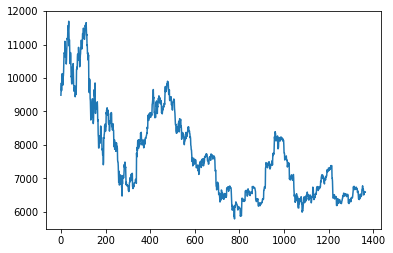

In [12]:
plt.plot(labels)
plt.show()

In [48]:
config = {
    'exp_name': 'bitcoin',
    'num_epochs': 2000,
    'learning_rate': 0.00001,
    'batch_size': 64,
    'sequence_length': 6,
    'max_to_keep': 5,
    'test_size': 0.20,
    'num_inputs': len(data_df.columns),
    'num_outputs': 1,
    'rnn_units': [20, 20],
    'lambda_l2_reg': 0.001,
    'E': 10,
    'E_prime': 30,
    'hidden_units': 20
}

config_path = 'configs/{}.json'.format(config['exp_name'])

with open(config_path, 'w') as config_file:
    json.dump(config, config_file)

config = process_config(config_path)
if os.path.exists(config.summary_dir):
    shutil.rmtree(config.summary_dir)
create_dirs([config.summary_dir, config.checkpoint_dir])

0

In [49]:
tf.reset_default_graph()

In [50]:
sess = tf.Session()

In [51]:
generator = DataGenerator(config, features, labels)

In [52]:
model = AdvLSTMModel(config)
# model = LSTMModel(config)

ValueError: Dimensions must be equal, but are 20 and 30 for 'Mul' (op: 'Mul') with input shapes: [6,?,20], [1,30].

In [261]:
logger = Logger(sess, config)

In [262]:
trainer = Trainer(sess, model, generator, config, logger)

In [263]:
trainer.train()

KeyboardInterrupt: 

In [264]:
evaler = Evaler(sess, model, generator, config)

In [265]:
train_loss, train_prediction, test_loss, test_prediction = evaler.evaluate()

In [266]:
train_loss

0.0008209951

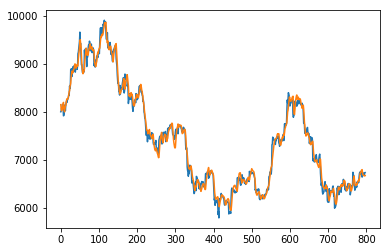

In [267]:
plt.plot(generator.labels_train[config.sequence_length:])
plt.plot(train_prediction)
plt.show()

In [268]:
test_loss

0.000518973

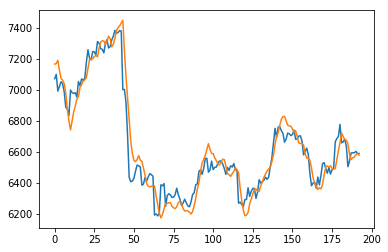

In [269]:
plt.plot(generator.labels_test[config.sequence_length:])
plt.plot(test_prediction)
plt.show()

In [270]:
correct = 0
wrong = 0
for i in range(1, len(test_prediction)):
    if np.sign(test_prediction[i][0] - generator.labels_test[i-1+config.sequence_length][0]) == np.sign(generator.labels_test[i+config.sequence_length][0] - generator.labels_test[i-1+config.sequence_length][0]):
        correct += 1
    else:
        wrong += 1

print(correct / (correct + wrong))

0.578125
